# GraalVM vs. Standard Java for Cloud Functions

After deploying the GraalVM and Standard Java functions to Cloud Run, get their URLs.

They will look like this:

* GraalVM function: https://my-func-graalvm-2yebdnw3bq-uc.a.run.app
* Standard Java function: https://my-func-java11-2yebdnw3bq-uc.a.run.app

In [1]:
GRAAL_FN = 'my-func-graalvm'
STD_JAVA_FN = 'my-func-java11'

URLS = {
    GRAAL_FN: 'https://my-func-graalvm-2yebdnw3bq-uc.a.run.app',
    STD_JAVA_FN: 'https://my-func-java11-2yebdnw3bq-uc.a.run.app'
}

In [2]:
import random
import requests
import shlex
import subprocess
import time

def run_command(cmd_string):
    output = subprocess.check_output(shlex.split(cmd_string)).strip()
    return output.decode('utf-8')

def redeploy(container_name):
    env_code = random.randint(1, 100000)
    command = 'gcloud run services update %s ' \
        '--update-env-vars FOO=%d --platform managed --region us-central1 --max-instances 1' % (container_name, env_code)
    run_command(command)
    return env_code

def send_request(function_url, coldstart=False):
    TOKEN = run_command('gcloud auth print-identity-token')
    if coldstart and '?coldstart' not in function_url:
        function_url += '?coldstart'
    
    # Notes on time.time() precision for linux: https://stackoverflow.com/a/1938096/906497
    # On linux & mac, time precision < 1 microsecond.
    start = time.time()
    response = requests.get(function_url, headers = {'Authorization': 'Bearer %s' % TOKEN})
    end = time.time()
    
    print(function_url + " | code: " + str(response.status_code))
    if response.status_code == 429:
        time.sleep(30)
    
    if response.status_code == 200:
        return end - start
    else:
        return send_request(function_url, coldstart)




## Cold Start Analysis

In this experiment, we measure the cold start time of the containers.

To trigger a cold start on each request, we pass the url parameter `?coldstart` in the URL.
The Java function checks for the prescence of `?coldstart` and will exit the Java process if provided. It is stopped via `System.exit()` which triggers a new instance to be created on the subsequent request:

```
if (httpRequest.getFirstQueryParameter("coldstart").isPresent()) {
      ScheduledExecutorService executorService = Executors.newScheduledThreadPool(1);
      try {
        executorService.schedule(() -> System.exit(0), 1, TimeUnit.SECONDS);
      } catch (Exception e) {
        System.err.println(e);
        System.exit(1);
      }
}
```

Also note, in the Cloud Run settings, `max_instances == 1` to ensure that only one instance is being used for the cold starts experiment.

In [ ]:
import csv
import os.path
import time

def write_data(request_tuple, file_name):
    with open(file_name, 'a') as file:
        file.write(",".join(map(lambda num: str(num), request_tuple)) + "\n")

def parse_numbers(filename):
    result = []
    with open(filename, 'r') as file:
        data = csv.reader(file, delimiter=',')
        for row in data:
            result.append((int(row[0]), float(row[1])))
        
    return result

# Sequential Cold Start Requests
def sequential_cold_start_request(fn_name, file_name, times=1000):
    print("Sequential cold start tests: " + fn_name)
    for i in range(times):
        result = send_request(URLS[fn_name], True)
        print("Request %s: time = %.3f" % (fn_name, result))
        datum = (int(round(time.time() * 1000)), result)
        write_data(datum, file_name)
        time.sleep(5)

for i in range(4):
    sequential_cold_start_request(STD_JAVA_FN, 'std_java_coldstart_bulk.txt', 500)
    sequential_cold_start_request(GRAAL_FN, 'graalvm_java_coldstart_bulk.txt', 500)
    
    

std_java_results = list(zip(*parse_numbers('std_java_coldstart_bulk.txt')))[1]
graalvm_results = list(zip(*parse_numbers('graalvm_java_coldstart_bulk.txt')))[1]

Sequential cold start tests: my-func-java11
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 5.548
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.786
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.969
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.710
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.879
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-f

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 2.918
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.449
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.040
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 429
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 0.407
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.227
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.180
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.362
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.636
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.148
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.150
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 429
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 2.950
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.620
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 2.922
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.397
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.712
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 2.967
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.606
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.406
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.309
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.509
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.558
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.292
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.221
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.338
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.662
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 4.005
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.748
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 4.135
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 4.400
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.190
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.939
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.245
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.029
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.117
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.382
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 4.077
https://my-func-jav

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.457
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.583
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.611
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 4.213
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.424
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.707
https://my-func-jav

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 2.823
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.025
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.481
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.248
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.150
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.593
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.246
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.072
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.621
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.393
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.348
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.200
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.345
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.471
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.168
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.028
ht

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.341
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 3.189
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.027
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.377
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.696
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.370
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
ht

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.348
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.172
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.027
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.392
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.388
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.475
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.222
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.029
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.395
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.362
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.123
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.443
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.232
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.025
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.025
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.045
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.026
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.026
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.025
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.064
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.108
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.416
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.383
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.143
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.446
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.638
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.414
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.029
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.060
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.048
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.093
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.031
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.432
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.026
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.418
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.132
ht

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.211
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.383
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.028
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.457
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.050
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.144
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.423
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.774
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.351
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.356
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.428
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.464
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.808
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.308
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.816
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.503
https://my-func-jav

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 2.883
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.347
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.937
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.651
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.306
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.767
https://my-func-jav

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.693
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.857
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.638
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.545
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.306
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.086
https://my-func-jav

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 4.007
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.291
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.291
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 429
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 0.400
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.955
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.324
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.036
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.640
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.276
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.166
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.129
https://my-func-jav

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 429
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 0.464
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.400
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.535
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.451
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.544
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.156
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.336
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.345
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 4.399
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.394
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.335
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.293
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 4.014
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.413
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.359
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.647
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.430
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.139
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.161
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.395
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart

https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.101
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.811
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 3.736
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 2.802
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 2.836
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-java11-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-java11: time = 2.965
https://my-func-jav

https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 2.441
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.993
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.691
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.696
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.670
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 503
https://my-func-graalvm-2yebdnw3bq-uc.a.run.app?coldstart | code: 200
Request my-func-graalvm: time = 0.803
ht

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def printStats(data, title):
    print(title)
    print('Mean = %.3f' % np.mean(data))
    print('Median (50p) = %.3f' % np.percentile(data, 50))
    print('95p = %.3f' % np.percentile(data, 95))
    print('99p = %.3f' % np.percentile(data, 99))
    print()

def plotHistogram(data, title, labels, range=None):
    plt.hist(data, bins=50, histtype='barstacked', label=labels, alpha=0.7, range=range)  # density=False would make counts
    plt.ylabel('Count')
    plt.xlabel('Latency (seconds)');
    plt.title(title)
    plt.legend()
    
plotHistogram([std_java_results], 'Cold Start Latencies', ['Standard Java 11'])
plotHistogram([graalvm_results], 'Cold Start Latencies (requests=100 each)', ['GraalVM'])
plt.show()

printStats(std_java_results, 'Standard Java Cold Start Latencies Percentiles')
printStats(graalvm_results, 'GraalVM Cold Start Latencies Percentiles')


## Sequential Warm Requests Experiment

Send requests sequentially to warmed Cloud Run instance.

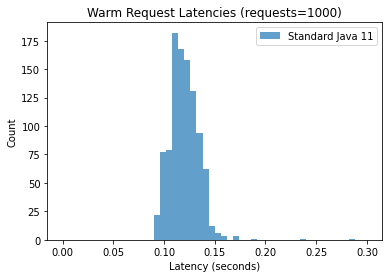

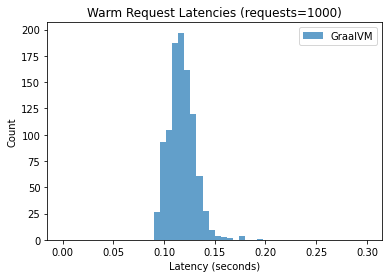

Std. Java Warm Latencies
Mean = 0.120
Median (50p) = 0.118
95p = 0.140
99p = 0.155

GraalVM Warm Latencies
Mean = 0.117
Median (50p) = 0.117
95p = 0.137
99p = 0.154



In [5]:
def sequential_requests(fn_name, times=1000):
    print("Normal Requests: " + fn_name)
    results = []
    for i in range(times):
        result = send_request(URLS[fn_name], False)
        results.append(result)
        print("Request %s: time = %.3f" % (fn_name, result))
    return results

def test_sequential_requests(func_name, file_name):
    if os.path.isfile(file_name):
        return parseNumbers(file_name)
    else:
        result = sequential_requests(func_name)
        write_data(result, file_name)
        return result

std_java_warm = test_sequential_requests(STD_JAVA_FN, 'std_java_warm_requests.txt')
graalvm_warm = test_sequential_requests(GRAAL_FN, 'graalvm_warm_requests.txt')

plotHistogram([std_java_warm], 'Warm Request Latencies (requests=1000)', ['Standard Java 11'], range=(0, 0.3))
plt.show()
plotHistogram([graalvm_warm], 'Warm Request Latencies (requests=1000)', ['GraalVM'], range=(0, 0.3))
plt.show()

printStats(std_java_warm, 'Std. Java Warm Latencies')
printStats(graalvm_warm, 'GraalVM Warm Latencies')


In [6]:
# Busy loop
# for i in range(90000):
#     TOKEN = run_command('gcloud auth print-identity-token')
#     send_request(URLS[GRAAL_FN], False)
#     send_request(URLS[STD_JAVA_FN], False)
#     time.sleep(1)